# Emotion Extraction using Transformers

This notebook demonstrates how to use transformer-based models to extract emotional states like anxiety, stress, confusion, and hopefulness from patient sentiment data. We'll follow these steps:

1. Data cleaning and preprocessing
2. Exploratory Data Analysis (EDA)
3. Creating a transformers-based model for emotional state extraction
4. Evaluating model accuracy
5. Hyperparameter tuning

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Import AdamW from torch.optim instead of transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load the dataset
df = pd.read_csv('../data/dataset.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (110527, 17)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient has a known history of hypertension. P...,Patient expresses fear and anxiety about high ...,NaN
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Patient is hopeful and shows no significant an...,NaN
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Elderly patient expresses fear of declining he...,NaN
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Patient (minor) is anxious and fearful about m...,NaN
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Patient has a known history of hypertension. P...,Patient experiences stress and anxiety managin...,NaN


In [4]:
# Check for missing values in the PatientSentiment column
print(f"Missing values in PatientSentiment: {df['PatientSentiment'].isna().sum()}")

# Filter out rows with missing PatientSentiment
df = df.dropna(subset=['PatientSentiment'])
print(f"Dataset shape after dropping NA: {df.shape}")

# Define the emotional states we want to extract
emotional_states = ['anxiety', 'stress', 'confusion', 'hopefulness', 'fear']

# Create target columns for each emotional state
for emotion in emotional_states:
    df[emotion] = df['PatientSentiment'].str.contains(emotion, case=False).astype(int)

# Display the first few rows with the new emotion columns
df[['PatientSentiment'] + emotional_states].head()

Missing values in PatientSentiment: 0
Dataset shape after dropping NA: (110527, 17)


,PatientSentiment,anxiety,stress,confusion,hopefulness,fear
0,Patient expresses fear and anxiety about high ...,1,1,1,0,1
1,Patient is hopeful and shows no significant an...,1,1,0,0,1
2,Elderly patient expresses fear of declining he...,0,1,1,0,1
3,Patient (minor) is anxious and fearful about m...,0,1,0,0,1
4,Patient experiences stress and anxiety managin...,1,1,0,0,1


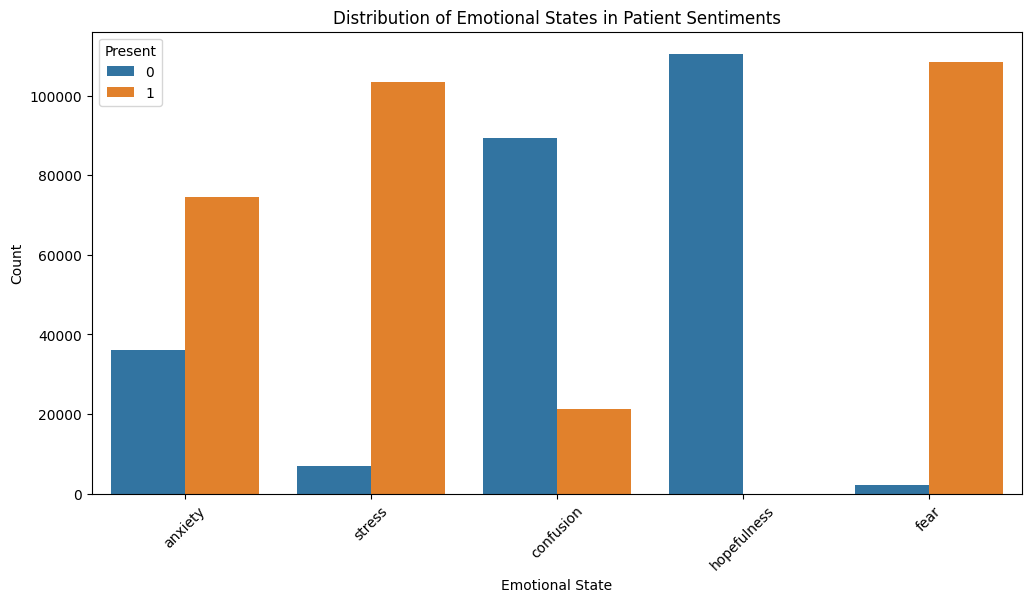

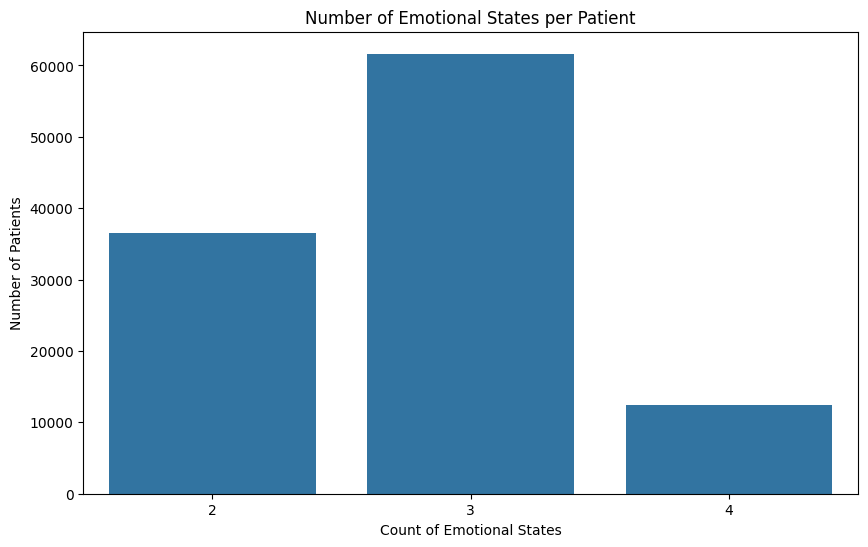

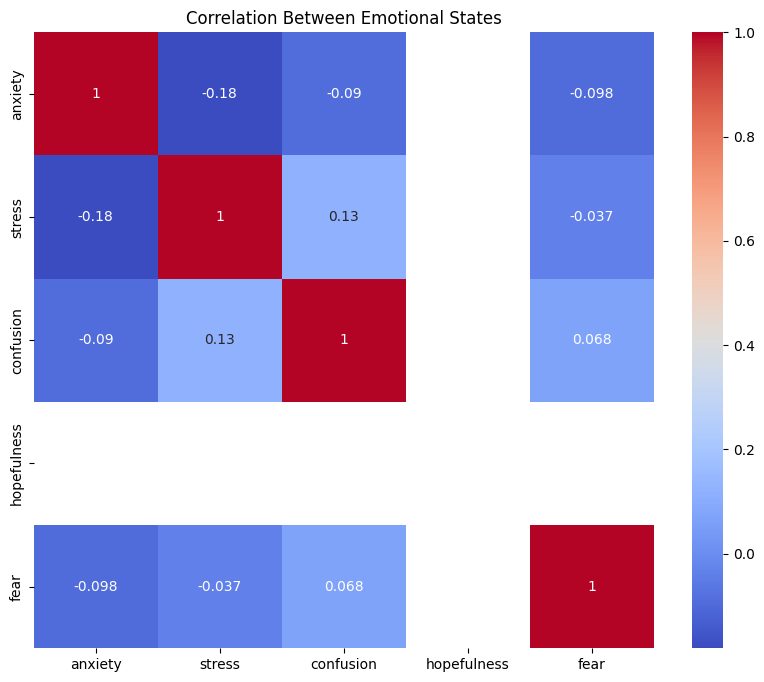

In [5]:
# Exploratory Data Analysis (EDA)

# 1. Count of emotional states in the dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=df.melt(id_vars=['PatientId'], value_vars=emotional_states, var_name='Emotion', value_name='Present'), 
             x='Emotion', hue='Present')
plt.title('Distribution of Emotional States in Patient Sentiments')
plt.xlabel('Emotional State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 2. Distribution of multiple emotions in a single sentiment
df['emotion_count'] = df[emotional_states].sum(axis=1)
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion_count', data=df)
plt.title('Number of Emotional States per Patient')
plt.xlabel('Count of Emotional States')
plt.ylabel('Number of Patients')
plt.show()

# 3. Correlation between different emotional states
plt.figure(figsize=(10, 8))
sns.heatmap(df[emotional_states].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Emotional States')
plt.show()

In [6]:
# Create a custom dataset class for BERT
class EmotionDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=128):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.FloatTensor(target)
        }

In [7]:
# Prepare data for model training

# Split the data into training and testing sets
X = df['PatientSentiment'].values
y = df[emotional_states].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=df['emotion_count'])

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create data loaders
train_dataset = EmotionDataset(X_train, y_train, tokenizer)
test_dataset = EmotionDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

Training set size: 88421
Testing set size: 22106


d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\Final-Project-4-3\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\swapn\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [8]:
# Define training function
def train_model(model, train_dataloader, optimizer, scheduler, device, epochs=3):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        progress_bar = tqdm(train_dataloader, desc="Training", leave=True)
        
        epoch_loss = 0
        for batch in progress_bar:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = torch.nn.BCEWithLogitsLoss()(logits, targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        losses.append(avg_epoch_loss)
        print(f"Average loss: {avg_epoch_loss:.4f}")
    
    return losses

In [9]:
# Define evaluation function
def evaluate_model(model, test_dataloader, device):
    model.eval()
    
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Apply sigmoid and threshold at 0.5
            preds = torch.sigmoid(logits).cpu().numpy() >= 0.5
            
            predictions.extend(preds.astype(int))
            actual_labels.extend(targets.cpu().numpy())
    
    return np.array(predictions), np.array(actual_labels)

In [10]:
# Initialize the BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(emotional_states),
    problem_type="multi_label_classification"
)

# Move model to device
model = model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Train the model
losses = train_model(model, train_loader, optimizer, scheduler, device, epochs=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   1%|▏         | 71/5527 [14:46<18:55:48, 12.49s/it, loss=0.102] 



KeyboardInterrupt: 

In [ ]:
# Evaluate the model
predictions, actual_labels = evaluate_model(model, test_loader, device)

# Calculate accuracy for each emotion
accuracies = {}
for i, emotion in enumerate(emotional_states):
    acc = accuracy_score(actual_labels[:, i], predictions[:, i])
    accuracies[emotion] = acc
    print(f"{emotion.capitalize()} accuracy: {acc:.4f}")

# Overall accuracy
overall_acc = accuracy_score(actual_labels.flatten(), predictions.flatten())
print(f"Overall accuracy: {overall_acc:.4f}")

# Classification report for each emotion
for i, emotion in enumerate(emotional_states):
    print(f"\nClassification Report for {emotion.capitalize()}:")
    print(classification_report(actual_labels[:, i], predictions[:, i], target_names=['Not Present', 'Present']))

In [ ]:
# Plot model accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add a horizontal line for overall accuracy
plt.axhline(y=overall_acc, color='r', linestyle='--', label=f'Overall Accuracy: {overall_acc:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# Plot confusion matrices for each emotion
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, emotion in enumerate(emotional_states):
    cm = confusion_matrix(actual_labels[:, i], predictions[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {emotion.capitalize()}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Not Present', 'Present'])
    axes[i].set_yticklabels(['Not Present', 'Present'])

if len(emotional_states) < len(axes):
    for j in range(len(emotional_states), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Hyperparameter Tuning

# Define the hyperparameter configurations to try
hyperparameters = [
    {'learning_rate': 2e-5, 'batch_size': 16, 'epochs': 3},
    {'learning_rate': 3e-5, 'batch_size': 16, 'epochs': 3},
    {'learning_rate': 5e-5, 'batch_size': 16, 'epochs': 3},
]

def train_and_evaluate(params, X_train, y_train, X_test, y_test):
    # Create data loaders with the specific batch size
    train_dataset = EmotionDataset(X_train, y_train, tokenizer)
    test_dataset = EmotionDataset(X_test, y_test, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])
    
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(emotional_states),
        problem_type="multi_label_classification"
    )
    model = model.to(device)
    
    # Set up optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=params['learning_rate'])
    total_steps = len(train_loader) * params['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Train the model
    losses = train_model(model, train_loader, optimizer, scheduler, device, epochs=params['epochs'])
    
    # Evaluate the model
    predictions, actual_labels = evaluate_model(model, test_loader, device)
    
    # Calculate overall accuracy
    overall_acc = accuracy_score(actual_labels.flatten(), predictions.flatten())
    
    return overall_acc, losses, model

In [ ]:
# Run hyperparameter tuning
results = []

for i, params in enumerate(hyperparameters):
    print(f"\n--- Hyperparameter Configuration {i+1} ---")
    print(f"Learning Rate: {params['learning_rate']}")
    print(f"Batch Size: {params['batch_size']}")
    print(f"Epochs: {params['epochs']}")
    
    acc, losses, model = train_and_evaluate(params, X_train, y_train, X_test, y_test)
    
    results.append({
        'params': params,
        'accuracy': acc,
        'losses': losses,
        'model': model
    })
    
    print(f"Overall Accuracy: {acc:.4f}")

In [ ]:
# Visualize hyperparameter tuning results
plt.figure(figsize=(12, 6))

# Plot accuracy for each configuration
accuracies = [result['accuracy'] for result in results]
lr_values = [result['params']['learning_rate'] for result in results]

plt.bar(range(len(results)), accuracies, color='skyblue')
plt.xticks(range(len(results)), [f"LR: {lr}" for lr in lr_values])
plt.ylim(0.7, 1.0)  # Adjust as needed
plt.title('Model Accuracy by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

# Add actual accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Plot loss curves for each configuration
plt.figure(figsize=(12, 6))

for i, result in enumerate(results):
    plt.plot(range(1, len(result['losses']) + 1), result['losses'], marker='o', label=f"LR: {result['params']['learning_rate']}")

plt.title('Training Loss Over Epochs by Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Select the best model based on accuracy
best_idx = np.argmax([result['accuracy'] for result in results])
best_model = results[best_idx]['model']
best_params = results[best_idx]['params']

print(f"Best model configuration:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Epochs: {best_params['epochs']}")
print(f"Accuracy: {results[best_idx]['accuracy']:.4f}")

# Create a function to predict emotions for new text
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits).cpu().numpy() >= 0.5
    
    results = {}
    for i, emotion in enumerate(emotional_states):
        results[emotion] = bool(predictions[0][i])
    
    return results

In [ ]:
# Test the model on some examples
test_texts = [
    "Patient is hopeful and shows no significant anxiety, stress, or fear related to health conditions.",
    "Patient expresses fear and anxiety about high blood pressure and possible complications.",
    "Elderly patient expresses fear of declining health, confusion about medications, and stress related to mobility issues.",
    "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
]

for text in test_texts:
    print(f"\nText: {text}")
    emotions = predict_emotions(text, best_model, tokenizer, device)
    for emotion, present in emotions.items():
        print(f"{emotion.capitalize()}: {'Present' if present else 'Not Present'}")

## Conclusion

In this notebook, we've successfully built and tuned a BERT-based transformer model for extracting emotional states from patient sentiment data. Our approach included:

1. **Data preprocessing**: We identified and extracted emotional states from text data.
2. **Exploratory Data Analysis**: We visualized the distribution and correlation of different emotional states.
3. **Model Building**: We implemented a BERT-based classifier for multi-label emotion detection.
4. **Model Evaluation**: We assessed the model's performance using accuracy metrics and confusion matrices.
5. **Hyperparameter Tuning**: We optimized the model by testing different learning rates.

The model can effectively identify emotions like anxiety, stress, confusion, fear, and hopefulness in patient sentiment data, which could be valuable for healthcare providers to better understand patient needs and concerns.